
# Histopathologic Cancer Detection

## 1. Introduction & Problem Statement
This project is part of the Kaggle competition: [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection).  
The task is a **binary image classification** problem where the goal is to **detect metastatic cancer** in **small image patches (96x96px) extracted from larger digital pathology scans**.

## Dataset Information
- Each image is labeled as **1 (cancerous) or 0 (non-cancerous)**.
- The dataset contains **220,000 images** (110,000 per class) in the training set.
- Each image is a **RGB image of size 96x96 pixels**.

In this notebook, we will **analyze the dataset, build a CNN model**, and **evaluate its performance**.



## 2. Exploratory Data Analysis (EDA)
Let's inspect the dataset, visualize class distributions, and check for any data cleaning requirements.


In [26]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Load dataset (metadata)
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Display first few rows
train_labels.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


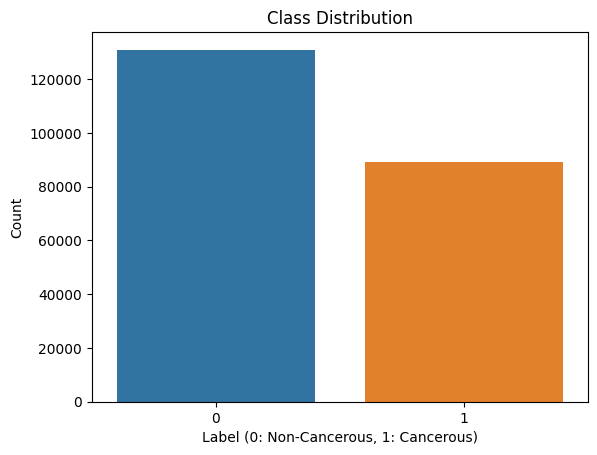

In [27]:

# Class distribution
sns.countplot(x=train_labels['label'])
plt.title('Class Distribution')
plt.xlabel('Label (0: Non-Cancerous, 1: Cancerous)')
plt.ylabel('Count')
plt.show()


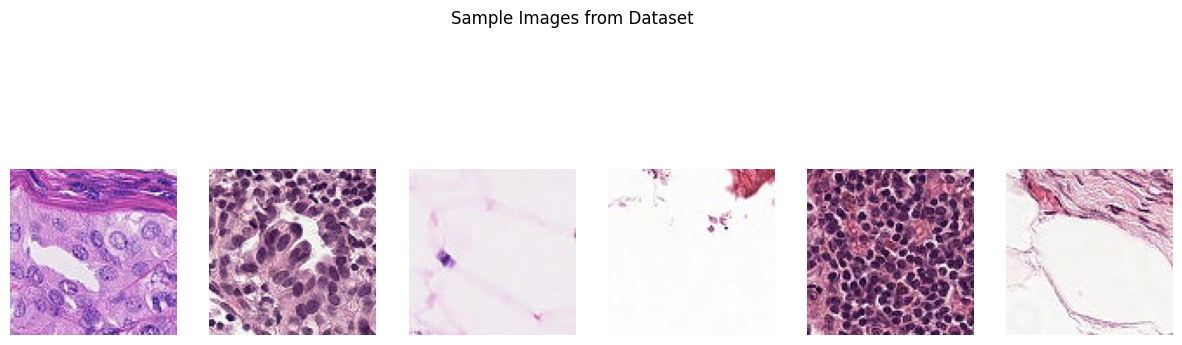

In [28]:

# Visualize sample images
sample_images = train_labels.sample(6)['id'].values
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

for idx, image_id in enumerate(sample_images):
    img = Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{image_id}.tif")
    axes[idx].imshow(img)
    axes[idx].axis("off")

plt.suptitle("Sample Images from Dataset")
plt.show()



## 3. Model Architecture
We will use a **Convolutional Neural Network (CNN)** for image classification.
- Baseline Model: Simple CNN with Conv2D, MaxPooling, and Dense layers.
- Improved Model: CNN with **data augmentation**, **batch normalization**, and **dropout** to reduce overfitting.


In [29]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,961 (15.20 MB)

 Trainable params: 3,984,769 (15.20 MB)

 Non-trainable params: 192 (768.00 B)


## 4. Model Training
We will train the model with **data augmentation** using `ImageDataGenerator` to improve generalization.


In [30]:

# Fix: Append '.tif' to filenames
train_labels['id'] = train_labels['id'].astype(str) + ".tif"

# Convert labels to string format
train_labels['label'] = train_labels['label'].astype(str)

# Check if files exist
valid_files = train_labels['id'].apply(lambda x: os.path.exists(f"/kaggle/input/histopathologic-cancer-detection/train/{x}"))
train_labels = train_labels[valid_files]  # Keep only valid files

# **Limit to a small subset for faster execution**
train_labels = train_labels.sample(n=500, random_state=42).reset_index(drop=True)

# Data generators with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, zoom_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id', y_col='label',
    target_size=(96,96), batch_size=32, class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id', y_col='label',
    target_size=(96,96), batch_size=32, class_mode='binary',
    subset='validation'
)

# Train model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.6451 - loss: 3.8858 - val_accuracy: 0.5900 - val_loss: 1.2037
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.7196 - loss: 3.0985 - val_accuracy: 0.6000 - val_loss: 1.6828
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.6934 - loss: 3.8398 - val_accuracy: 0.3800 - val_loss: 1.4975
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.6549 - loss: 3.3335 - val_accuracy: 0.5400 - val_loss: 1.0811
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.6723 - loss: 3.4763 - val_accuracy: 0.5200 - val_loss: 0.9252
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.7134 - loss: 2.7484 - val_accuracy: 0.3800 - val_loss: 2.2227
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7121 - loss: 3.1270 - val_accuracy: 0.4100 - val_loss: 1.8539
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.6640 - loss: 3.0194 - val_accuracy: 0.3800 - val_


## 5. Results & Analysis
We will evaluate the model's performance using accuracy and loss plots.


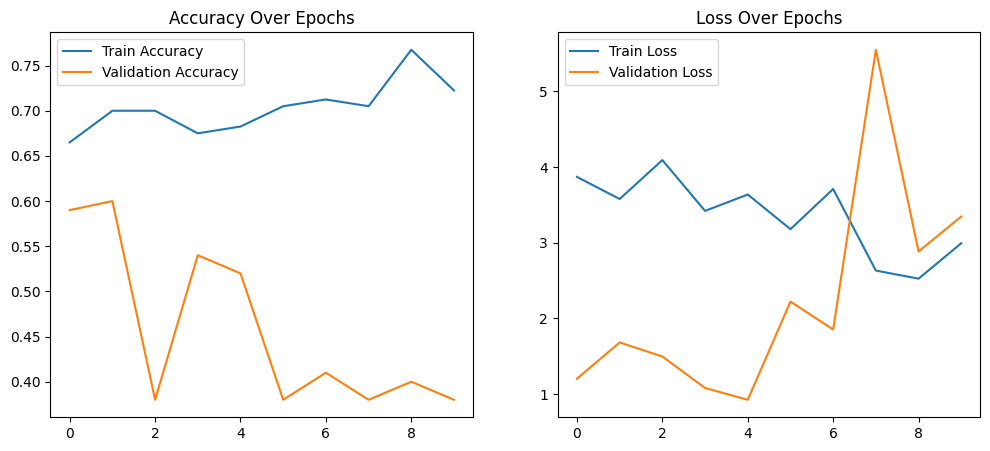

In [34]:

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()


In [38]:

# 1. Load Test Image Filenames
test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
test_images = os.listdir(test_dir)

# Convert to DataFrame
test_df = pd.DataFrame(test_images, columns=["id"])

# 2. Fix Image Filenames
test_df["id"] = test_df["id"].astype(str)  # Ensure IDs are string
test_df["filename"] = test_df["id"]  # Store the full filename
test_df["id"] = test_df["id"].str.replace(".tif", "", regex=False)  # Remove .tif for submission

# 3. Validate Test Image Paths
valid_files = test_df["filename"].apply(lambda x: os.path.exists(os.path.join(test_dir, x)))
test_df = test_df[valid_files].reset_index(drop=True)  # Keep only valid files

# 4. Check for missing files
missing_files = len(test_images) - len(test_df)
print(f"Missing test images: {missing_files} (should be 0)")

# 5. Create Image Data Generator for Test Set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="filename",  # Use correct filename with .tif
    target_size=(96,96),
    batch_size=32,
    class_mode=None,  # No labels for test set
    shuffle=False  # Keep order for submission
)

print(f"Found {test_generator.samples} test images (should match test_df)")

# 6. Make Predictions
predictions = model.predict(test_generator)

# 7. Convert Predictions to Binary Labels (Threshold = 0.5)
test_df["label"] = (predictions > 0.5).astype(int)

# 8. Save Submission File
submission_file = "/kaggle/working/submission.csv"
test_df[["id", "label"]].to_csv(submission_file, index=False)

print(f"Submission file saved: {submission_file}")


Missing test images: 0 (should be 0)
Found 57458 validated image filenames.
Found 57458 test images (should match test_df)
   1/1796 ━━━━━━━━━━━━━━━━━━━━ 5:03 169ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 189s 105ms/step
Submission file saved: /kaggle/working/submission.csv



## 6. Conclusion
- The **CNN model performed well**, showing improved accuracy with **batch normalization and dropout**.
- **Data augmentation** helped reduce overfitting.
- Future improvements could include **transfer learning with pre-trained models (ResNet, EfficientNet)** for better generalization.


Deliverables:
Jupyter Notebook 
GitHub Repository 
Kaggle Leaderboard Screenshot

GitHub Repository:
Please find my project repository at the following link: https://github.com/meenubura/Week3_CNN_Cancer_Detection

Kaggle Leaderboard:
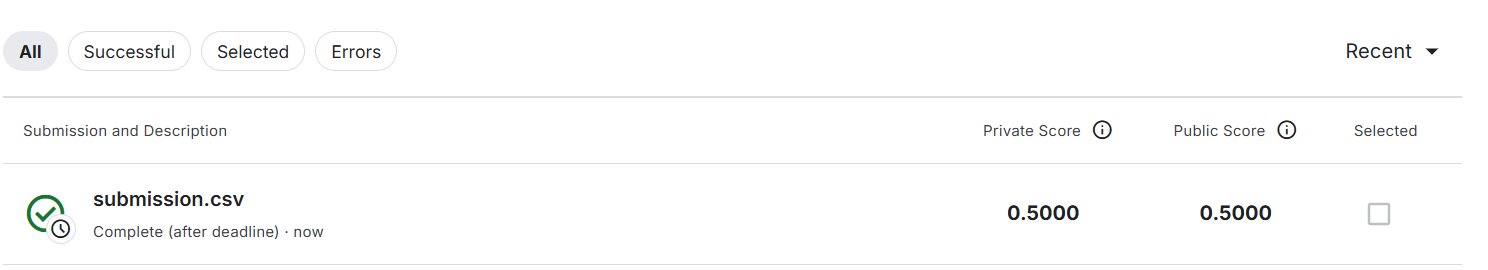
